# Setup

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
from six.moves import range, zip, map, reduce, filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
plt.rc('figure', figsize=(7.0, 5.0))

In [5]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback

In [6]:
def plot_callback(func,p=20):
    def plot_epoch_end(epoch,logs):
        if epoch == 0 or (epoch+1) % p == 0:
            plt.clf(); func(); plt.title('epoch %d' % (epoch+1))
            display.clear_output(wait=True); display.display(plt.gcf())
    def clear(*args):
        plt.clf()
    return LambdaCallback(on_epoch_end=plot_epoch_end,on_train_end=clear)

In [7]:
def plot_loss(hist):
    plt.figure()
    plt.plot(hist.epoch,hist.history['loss'],label='loss');
    if 'val_loss' in hist.history:
        plt.plot(hist.epoch,hist.history['val_loss'],label='val_loss'); plt.legend()
    plt.xlabel('epoch'); plt.ylabel('loss');

# Linear Regression

## Data

Line with slope $m$ going through the origin + (Gaussian) noise $n$: $f(x) = m \cdot x + n$

In [8]:
def f(x,m=1,n=0):
    return m*x + n

In [9]:
def plot_f(x,y,y_gt=None,y_hat=None):
    legend = ['y']
    plt.plot(x,y,'o',color='C0')
    if y_gt is not None:
        plt.plot(x,y_gt,'--',color='C0')
        legend.append('y_gt')
    if y_hat is not None:
        plt.plot(x,y_hat,color='C1')
        legend.append('y_hat')
    plt.xlabel('x'); plt.ylabel('f(x)')
    plt.legend(legend,loc='upper left')

In [10]:
m_gt = 2

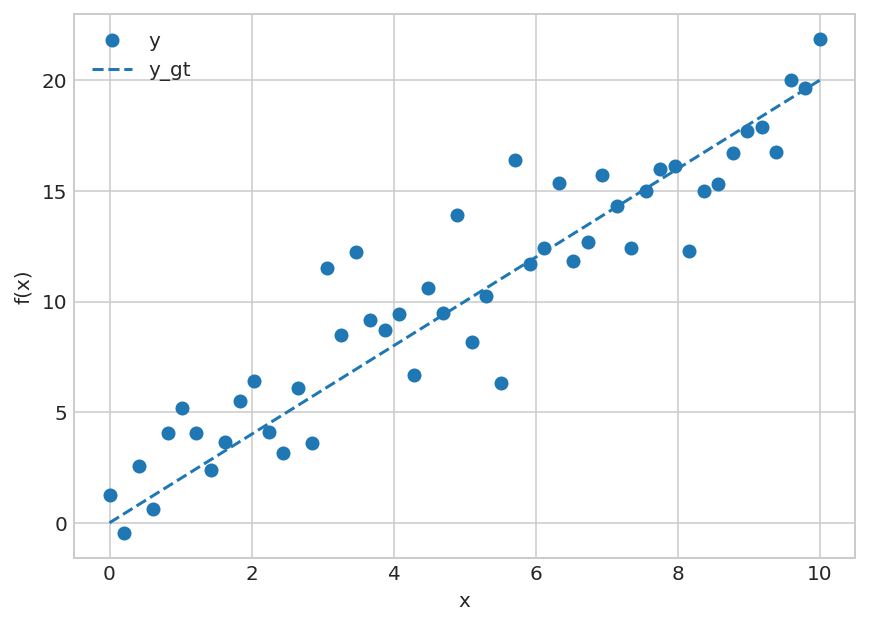

In [11]:
N = 50
x = np.linspace(0,10,N)
n = np.random.normal(scale=2,size=x.shape) # Gaussian noise with mean 0 and standard deviation 2
y    = f(x,m_gt,n)
y_gt = f(x,m_gt,0) # true line without noise
plot_f(x,y,y_gt)

## Closed-form solution

Which line (slope) explains the data "best"?
To answer that, we need to assign a cost to each slope $m$,
here based on the _mean squared error_ (MSE):

$$
\large
C(m) = \frac{1}{N} \sum\nolimits_i (y_i - m \cdot x_i)^2
$$

Now find the "best" slope $\hat{m}$ that minimizes the cost function:

$$
\large
\hat{m}
\quad=\quad \mathsf{arg\,min}_m C(m)
\quad=\quad \mathsf{arg\,min}_m \lVert {\bf y} - m \cdot {\bf x} \rVert^2_2
\quad=\quad \color{blue}{({\bf x}^\mathsf{T}{\bf x})^{-1}({\bf x}^\mathsf{T}{\bf y})}
$$

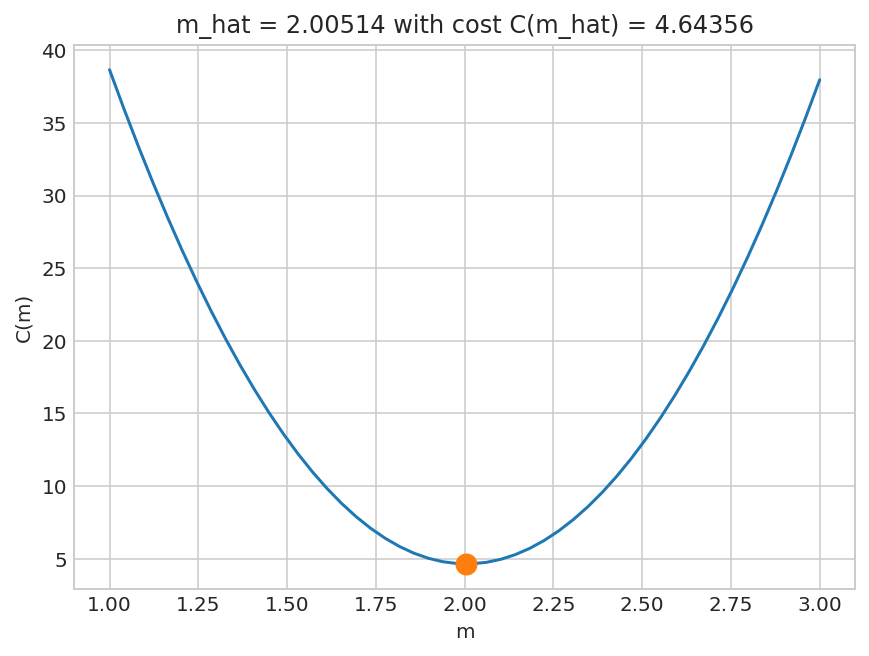

In [12]:
def C(m):
    return np.mean( (y-m*x)**2 )

m_candidates = np.linspace(m_gt-1,m_gt+1)
plt.plot(m_candidates,list(map(C,m_candidates))); plt.xlabel('m'); plt.ylabel('C(m)');

m_hat = x.dot(y) / x.dot(x) # closed-form solution
plt.plot(m_hat,C(m_hat),'o',color='C1',markersize=10)
plt.title('m_hat = %g with cost C(m_hat) = %g' % (m_hat, C(m_hat)));

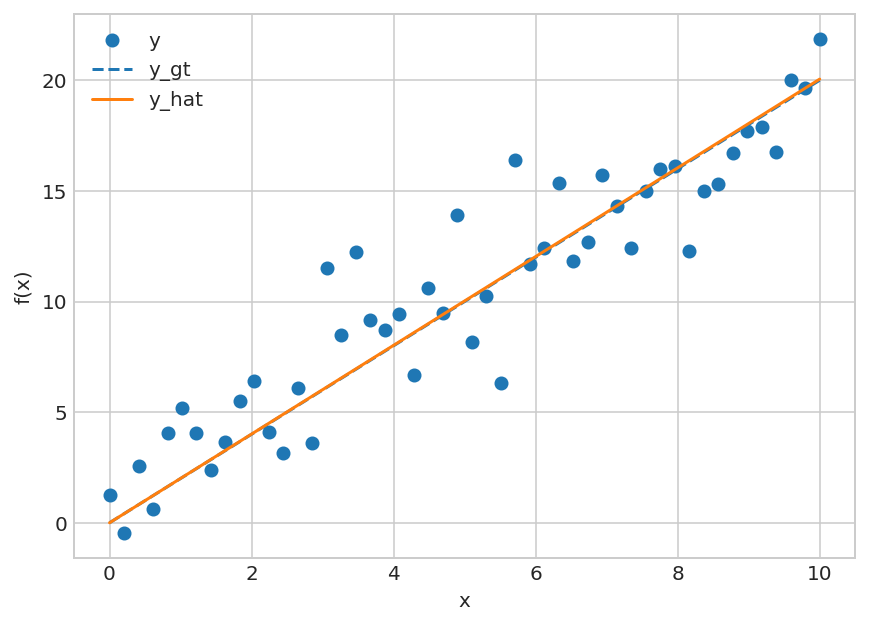

In [13]:
plot_f(x,y,y_gt,y_hat=f(x,m_hat,0))

## Iterative solution

### [Keras](https://keras.io/)

- sequential vs. functional model API
- loss and optimizer
- training: batch_size, epoch
- use model for prediction
- inspect learned model

### Define the model

Three ways to define the same model of a line that passes through the origin:

In [14]:
def get_model():
    model = Sequential([
        Dense(1, use_bias=False, input_shape=(1,), name='y'),
    ])
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
y (Dense)                    (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [15]:
def get_model():
    model = Sequential()
    model.add( Dense(1, use_bias=False, input_shape=(1,), name='y') )
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
y (Dense)                    (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [16]:
def get_model():
    l_in  = Input(shape=(1,),        name='x')
    l_out = Dense(1, use_bias=False, name='y')(l_in)
    model = Model(inputs=l_in,outputs=l_out)
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 1)                 0         
_________________________________________________________________
y (Dense)                    (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


### Choose a loss and optimizer

In [17]:
def compile_model(model,lr=0.01):
    model.compile(loss='mean_squared_error',optimizer=Adam(lr))

compile_model(model)

### Training

In [18]:
model.fit(x,y,batch_size=N,epochs=10);

Epoch 1/10
50/50 [==============================] - 1s 24ms/step - loss: 437.7659
Epoch 2/10
50/50 [==============================] - 0s 67us/step - loss: 435.9704
Epoch 3/10
50/50 [==============================] - 0s 82us/step - loss: 433.9039
Epoch 4/10
50/50 [==============================] - 0s 60us/step - loss: 431.7196
Epoch 5/10
50/50 [==============================] - 0s 61us/step - loss: 429.4719
Epoch 6/10
50/50 [==============================] - 0s 59us/step - loss: 427.1865
Epoch 7/10
50/50 [==============================] - 0s 56us/step - loss: 424.8777
Epoch 8/10
50/50 [==============================] - 0s 45us/step - loss: 422.5542
Epoch 9/10
50/50 [==============================] - 0s 40us/step - loss: 420.2217
Epoch 10/10
50/50 [==============================] - 0s 42us/step - loss: 417.8843


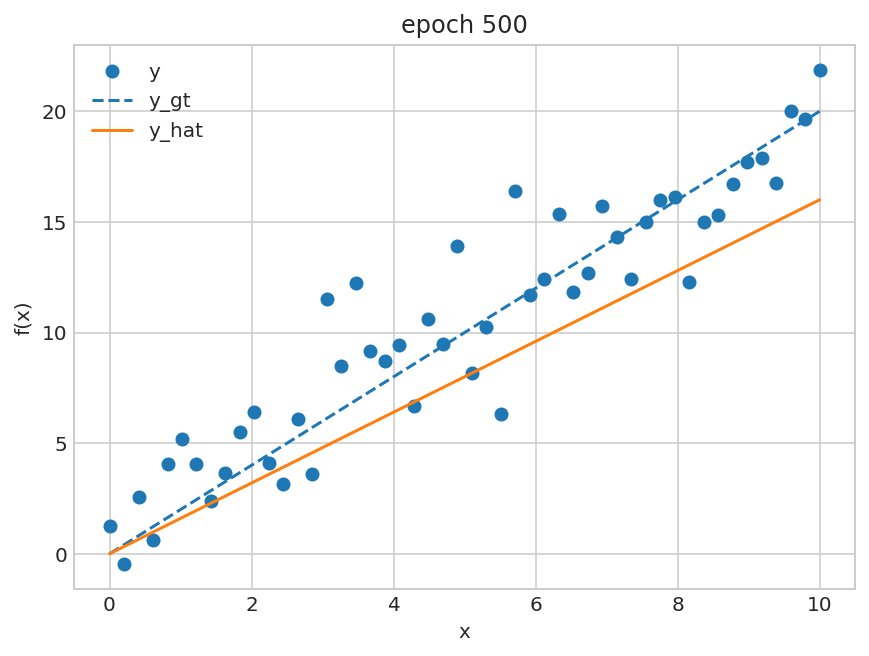

<Figure size 504x360 with 0 Axes>

In [19]:
model.fit(x,y,batch_size=N,epochs=500,verbose=0,
          callbacks=[plot_callback(lambda:plot_f(x,y,y_gt,model.predict(x)))]);

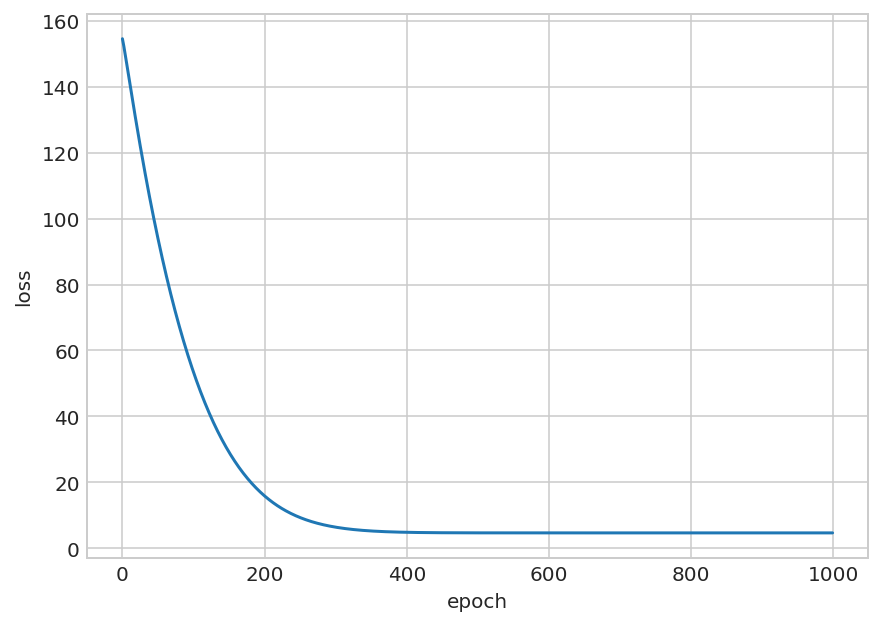

In [20]:
model = get_model()
compile_model(model)

hist = model.fit(x,y,batch_size=N,epochs=1000,verbose=False)
plot_loss(hist)

### Prediction and inspection

In [21]:
weights = model.get_layer('y').get_weights()
print('weights =', weights) # m_hat = weights[0][0][0]
print('loss    =', hist.history['loss'][-1])

weights = [array([[2.005136]], dtype=float32)]
loss    = 4.643564224243164


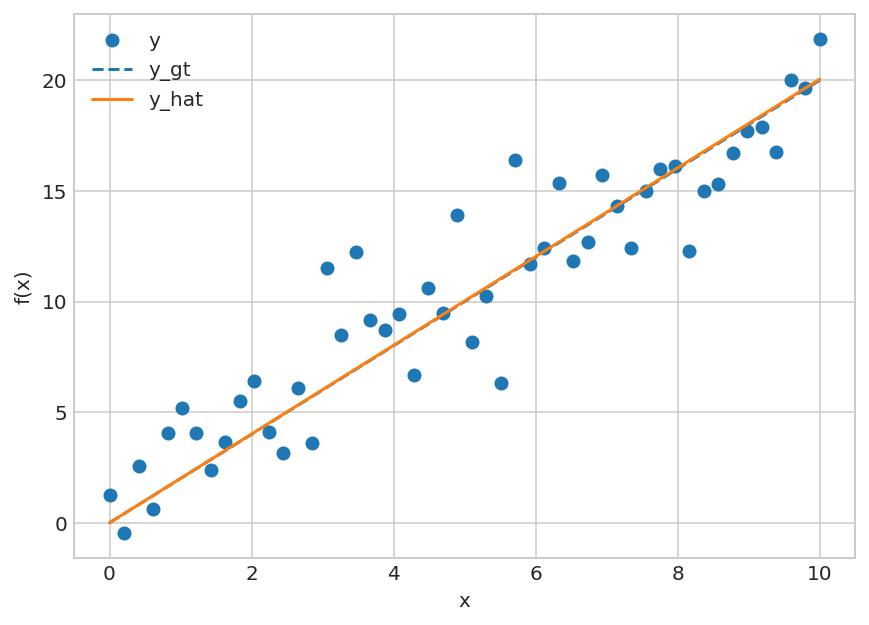

In [22]:
plot_f(x,y,y_gt,model.predict(x))

### Larger & deeper model → more powerful?

In [23]:
model = Sequential()
model.add( Dense(16, input_shape=(1,)) )
model.add( Dense(16) )
model.add( Dense(1, name='y') )
model.summary()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
y (Dense)                    (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


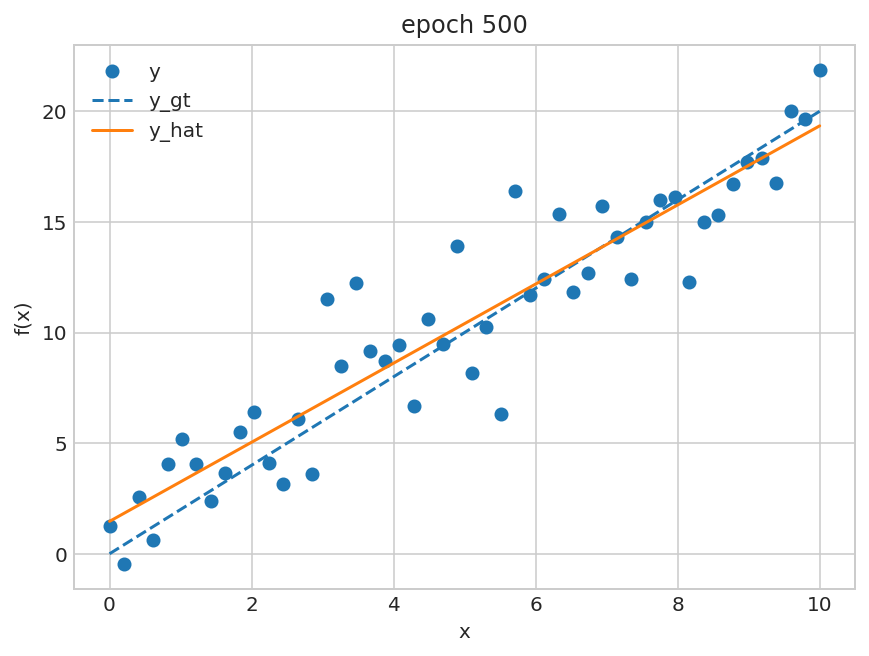

<Figure size 504x360 with 0 Axes>

In [24]:
model.fit(x,y,batch_size=N,epochs=500,verbose=0,
          callbacks=[plot_callback(lambda:plot_f(x,y,y_gt,model.predict(x)))]);

### Activation functions

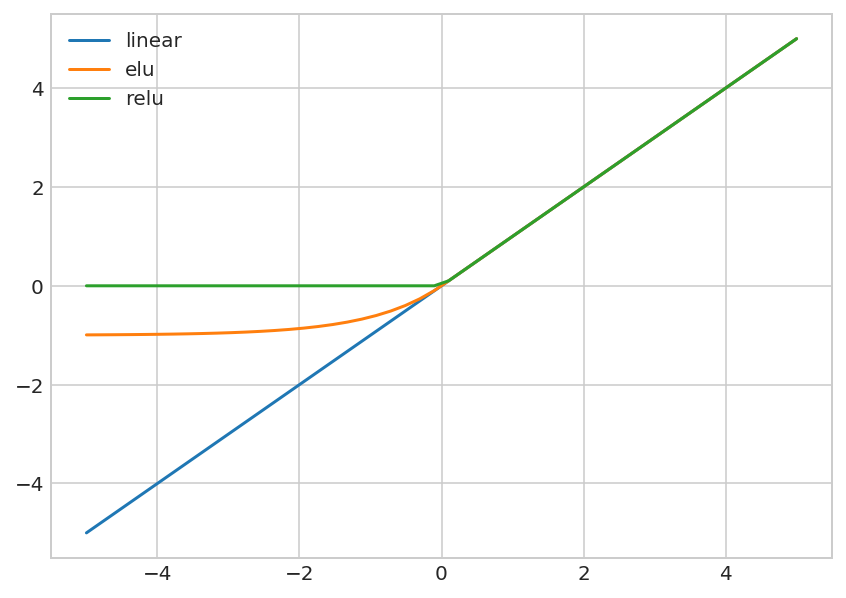

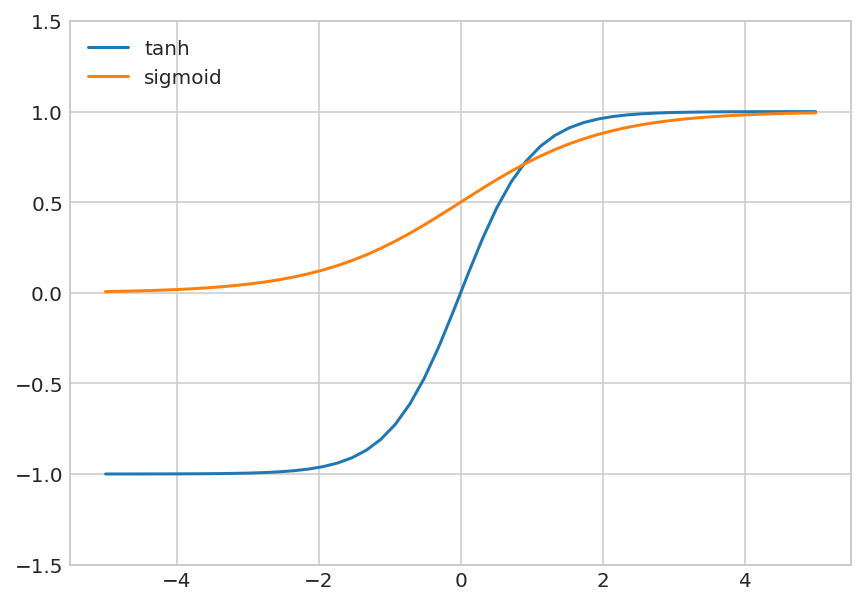

In [25]:
v = np.linspace(-5,5)
Identity = keras.layers.Lambda(lambda x: x+0,input_shape=(1,)) # to avoid an issue in keras
def plot_activations(activations_names):
    plt.figure()
    for name in activations_names:
        model = Sequential([Identity,Activation(name)])
        plt.plot(v,model.predict(v))    
    plt.legend(activations_names,loc='upper left')

plot_activations(('linear','elu','relu'))
plot_activations(('tanh','sigmoid')); plt.ylim((-1.5,1.5));

### Larger & deeper model → more powerful with non-linear activation functions

In [26]:
activation_name = 'tanh'
model = Sequential()
model.add( Dense(16, input_shape=(1,)) )
model.add( Activation(activation_name) )
model.add( Dense(16) )
model.add( Activation(activation_name) )
model.add( Dense(16) )
model.add( Activation(activation_name) )
model.add( Dense(1, name='y') )
model.summary()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_8 (Activation)    (None, 16)                0         
_________________________________________________________________
y (Dense)                    (None, 1)                 17        
Total para

In [27]:
# validation data
N_val = 25
x_val = np.linspace(0,10,N_val)
n_val = np.random.normal(scale=2,size=x_val.shape) # Gaussian noise with mean 0 and standard deviation 2
y_val = f(x_val,m_gt,n_val)

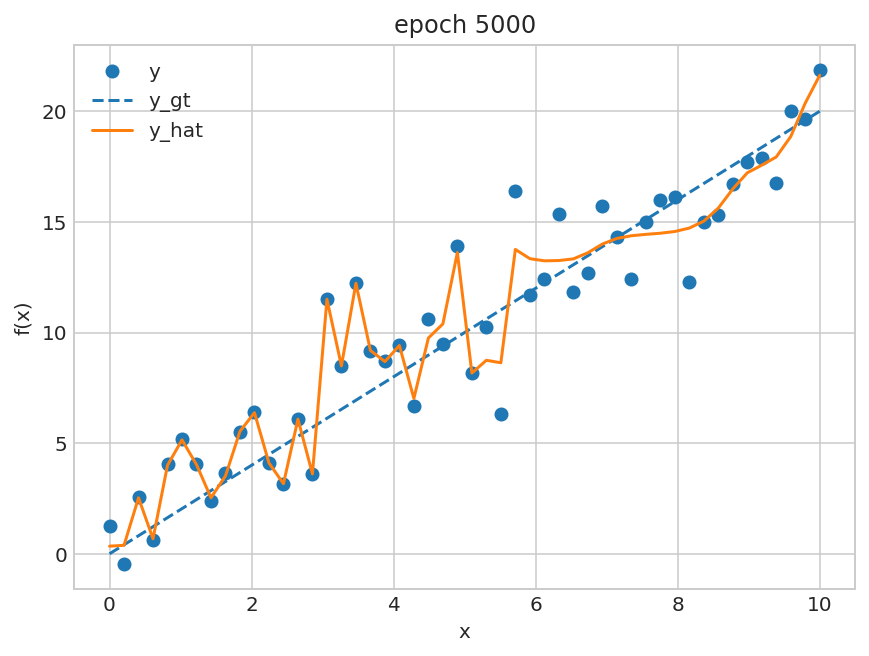

<Figure size 504x360 with 0 Axes>

In [28]:
hist = model.fit(x,y,validation_data=(x_val,y_val),batch_size=N,epochs=5000,verbose=0,
                 callbacks=[plot_callback(lambda:plot_f(x,y,y_gt,model.predict(x)),200)]);

#### Overfitting

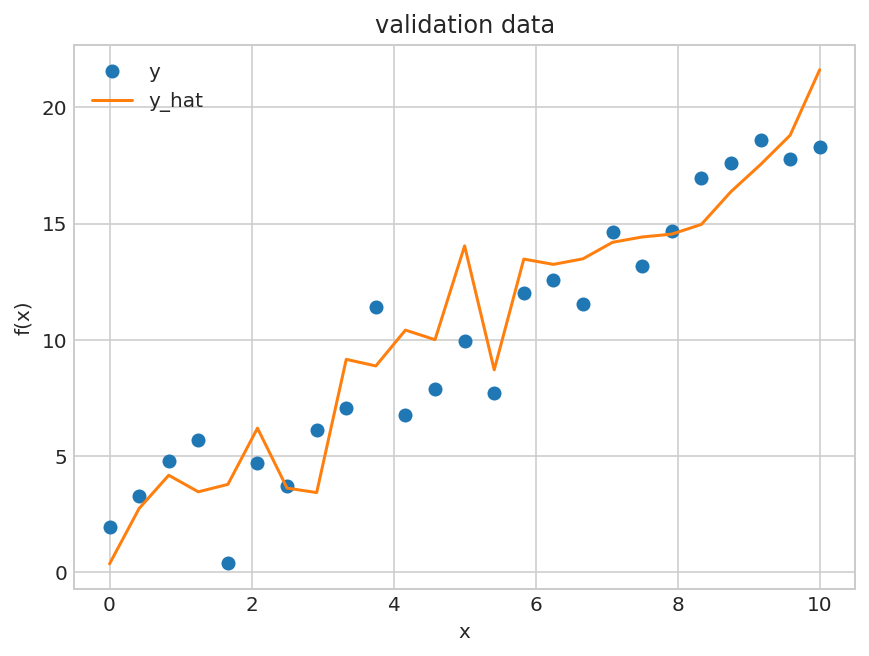

In [29]:
plot_f(x_val,y_val,y_hat=model.predict(x_val))
plt.title('validation data');

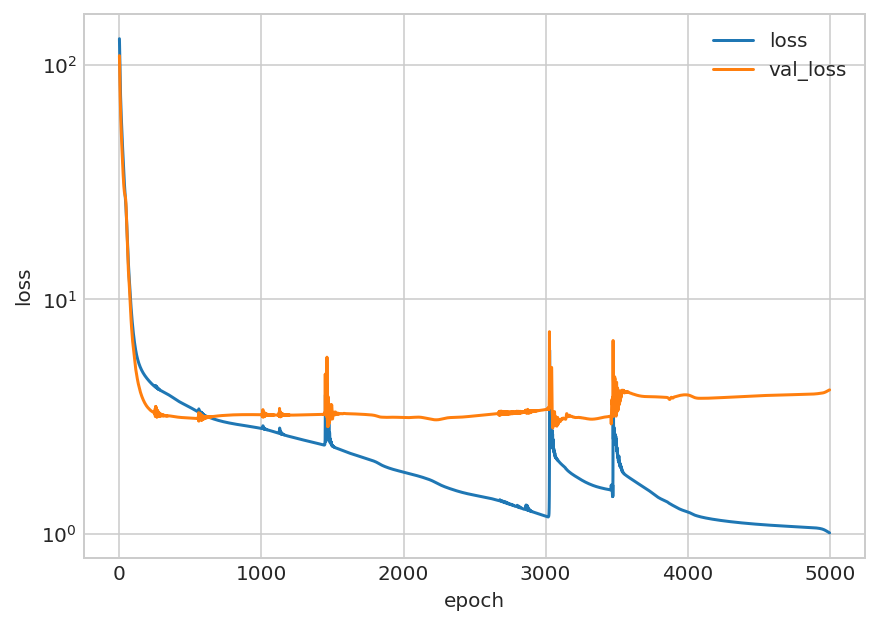

In [30]:
plot_loss(hist)
plt.yscale('log');

# Non-linear Regression

## Data

In [31]:
def f(x,n=0):
    return x * np.sin(x) + n

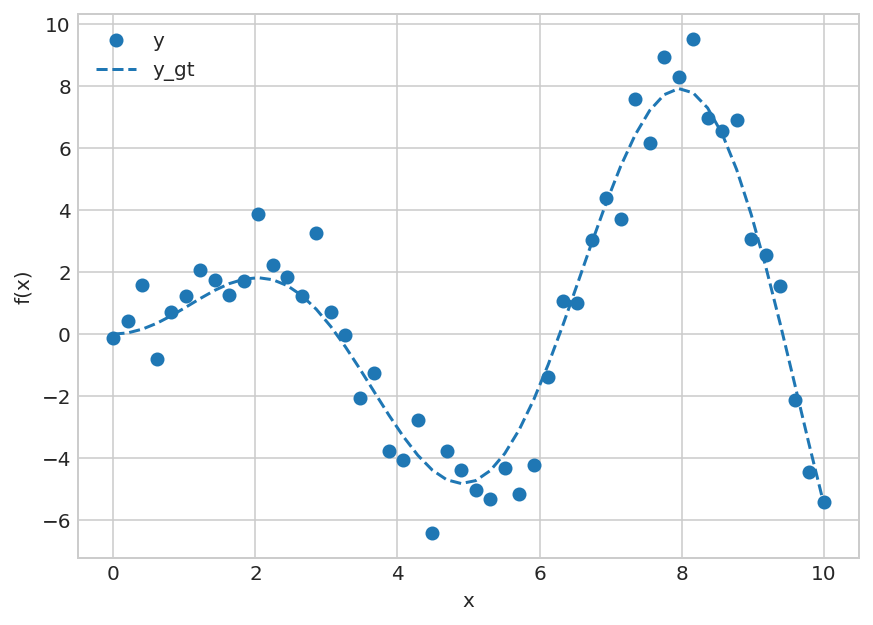

In [32]:
N = 50
x = np.linspace(0,10,N)
n = np.random.normal(scale=1,size=x.shape)
y    = f(x,n)
y_gt = f(x,0)
plot_f(x,y,y_gt)

## Model fitting

In [33]:
l_in  = Input(shape=(1,), name='x')
t = l_in
nlayers = 2
for i in range(nlayers):
    t = Dense(8, name='layer_%d'%(i+1))(t)
    t = Activation('elu', name='layer_%d_act'%(i+1))(t)
l_out = Dense(1, name='y')(t)
model = Model(inputs=l_in,outputs=l_out)
model.summary()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 1)                 0         
_________________________________________________________________
layer_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
layer_1_act (Activation)     (None, 8)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
layer_2_act (Activation)     (None, 8)                 0         
_________________________________________________________________
y (Dense)                    (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


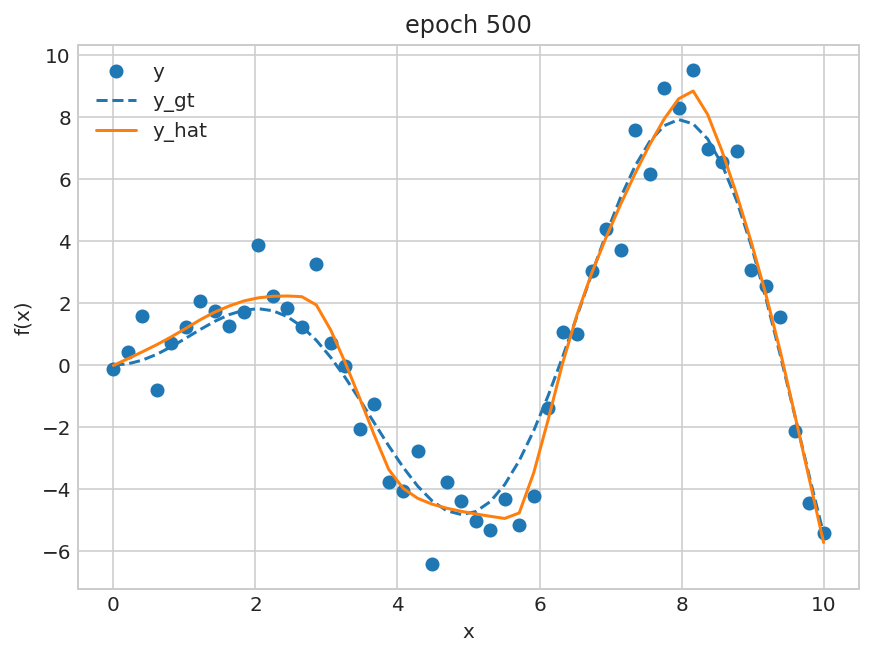

<Figure size 504x360 with 0 Axes>

In [34]:
hist = model.fit(x, y, batch_size=N, epochs=500,verbose=0,
                 callbacks=[plot_callback(lambda: plot_f(x,y,y_gt,model.predict(x)), 20)]);

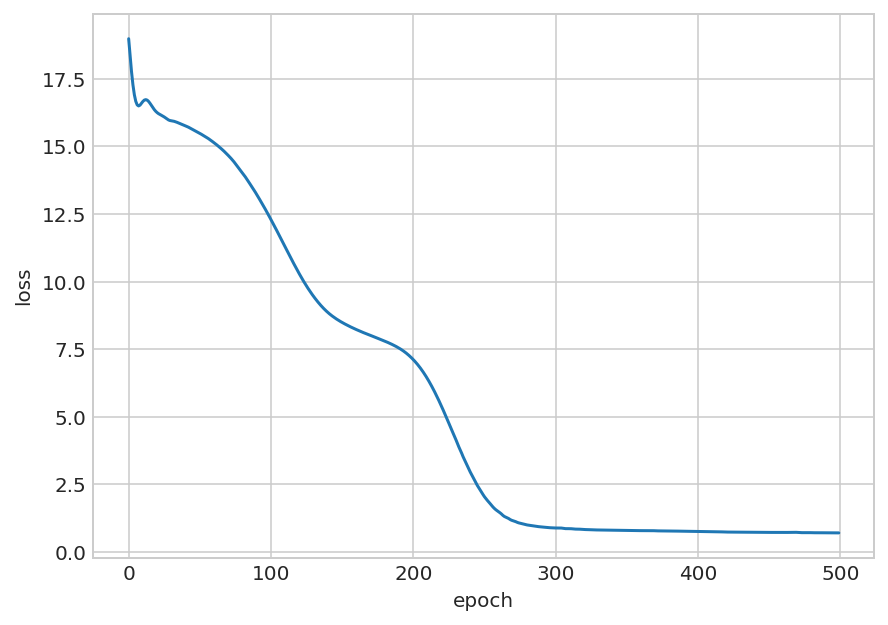

In [35]:
plot_loss(hist)

## Prediction and visualization

Prediction for unseen data points:

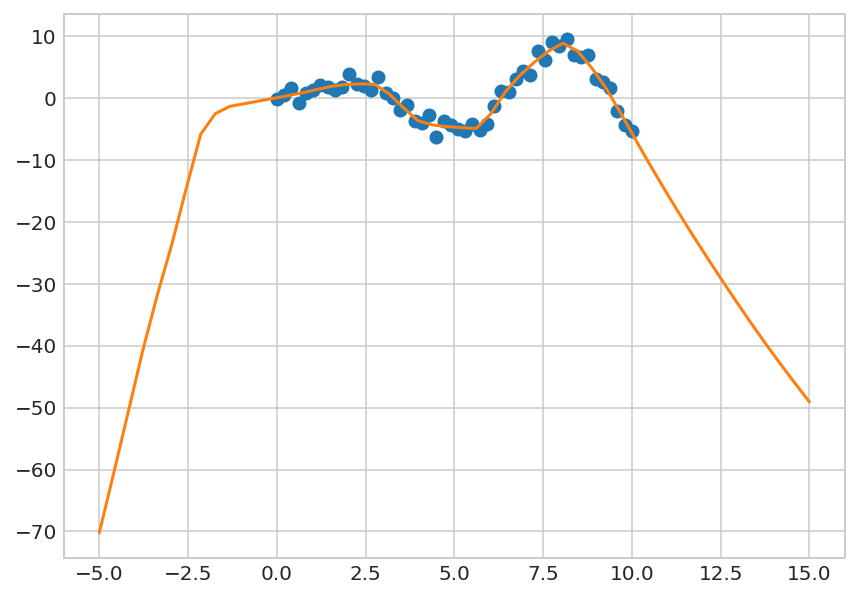

In [36]:
xx = np.linspace(-5,15)
plt.plot(x,y,'o')
plt.plot(xx,model.predict(xx));

Implicitly learned basis functions:

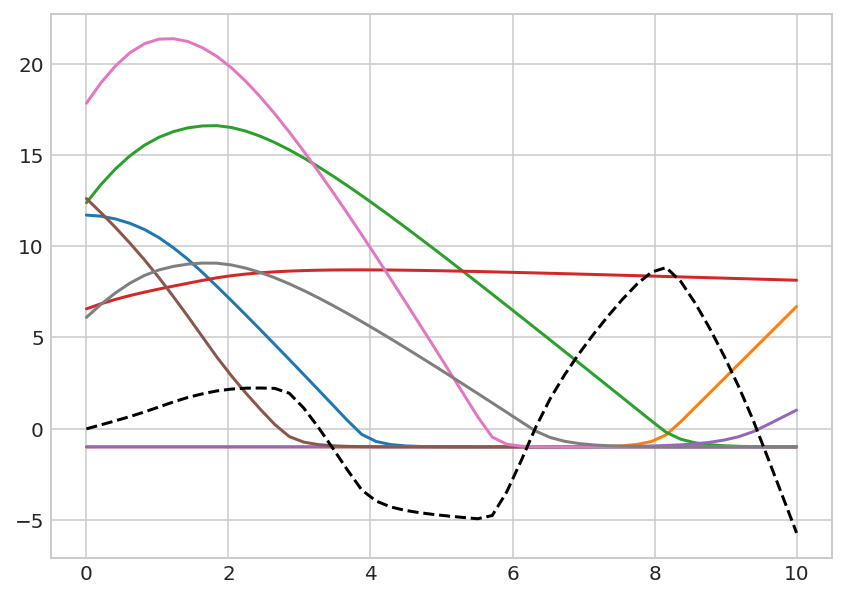

In [37]:
model_vis = Model(model.input, model.get_layer('layer_%d_act'%nlayers).output)
plt.plot(x,model_vis.predict(x));
plt.plot(x,model.predict(x),'--k');